API Documentation: https://support.datacite.org/docs/api

RADS Metadata Analysis: https://ajhmohr.github.io/rads_metadata/

DataCite Python API: https://datacite.readthedocs.io/en/latest/

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Pulling Data from DataCite API

In [2]:
URL = "https://api.datacite.org/dois?query=creators.affiliation.name:%22University%20of%20Kentucky%22*&affiliation=true&resource-type-id=Dataset"
start_response = requests.get(URL)
start_json_data = start_response.json()

Get a list of key metadata for all DataCite-registered DOI's:

In [21]:
done = False
results_dict = {"title" : [], "ukResearcher" : [], "other_ukResearcher": [], "affiliation" : [], "resourceType" : [], "resourceTypeGeneral" : [], "doi" : [], "repository" : [], "publicationYear" : [], "rights" : [], "viewCount" : [], "downloadCount" : [], "referenceCount" : []}
page_count = 1
response = start_response
json_data = start_json_data

while not done:
    for record in json_data["data"]:
        record_created = False
        addl_uk_researcher = []
        for creator in record["attributes"]["creators"]:
            for affiliation in creator["affiliation"]:
                #For records with multiple UK creators, only create one row, but list other UK creators
                if not record_created:
                    if affiliation["name"] == "University of Kentucky":
                        try:
                            results_dict["title"].append(record["attributes"]["titles"][0]["title"])
                        except:
                            results_dict["title"].append(None)
                        try:
                             results_dict["ukResearcher"].append(creator["name"])
                        except:
                            results_dict["ukResearcher"].append(None)
                        try:
                            results_dict["affiliation"].append(affiliation["name"])
                        except:
                            results_dict["affiliation"].append(None)
                        try:
                            results_dict["resourceType"].append(record["attributes"]["types"]["resourceType"])
                        except:
                            results_dict["resourceType"].append(None)
                        try:
                            results_dict["resourceTypeGeneral"].append(record["attributes"]["types"]["resourceTypeGeneral"])
                        except:
                            results_dict["resourceTypeGeneral"].append(None)        
                        try:
                            results_dict["doi"].append(record["id"])
                        except:
                            results_dict["doi"].append(None)
                        try:
                            results_dict["repository"].append(record["attributes"]["publisher"])
                        except:
                            results_dict["repository"].append(None)
                        try:
                            results_dict["publicationYear"].append(record["attributes"]["publicationYear"]) 
                        except:
                            results_dict["publicationYear"].append(None)
                        try:
                            results_dict["rights"].append(record["attributes"]["rightsList"][0]["rights"])
                        except:
                            results_dict["rights"].append(None)
                        try:
                            results_dict["viewCount"].append(record["attributes"]["viewCount"])
                        except:
                            results_dict["viewCount"].append(None)
                        try:
                            results_dict["downloadCount"].append(record["attributes"]["downloadCount"])
                        except:
                            results_dict["downloadCount"].append(None)
                        try:
                            results_dict["referenceCount"].append(record["attributes"]["referenceCount"])
                        except:
                            results_dict["referenceCount"].append(None)
                        record_created = True
                else:
                    if affiliation["name"] == "University of Kentucky":
                        addl_uk_researcher.append(creator["name"])
        results_dict["other_ukResearcher"].append(addl_uk_researcher)
    
    print(f'Done with page {page_count}')
    try:
        next_key = json_data["links"]["next"]
        response = requests.get(next_key)
        json_data = response.json()
        page_count += 1
    except:
        done = True

results_df = pd.DataFrame(results_dict)

Done with page 1
Done with page 2
Done with page 3
Done with page 4
Done with page 5
Done with page 6
Done with page 7
Done with page 8
Done with page 9
Done with page 10
Done with page 11
Done with page 12
Done with page 13
Done with page 14
Done with page 15
Done with page 16
Done with page 17
Done with page 18
Done with page 19
Done with page 20
Done with page 21
Done with page 22
Done with page 23
Done with page 24
Done with page 25
Done with page 26
Done with page 27
Done with page 28
Done with page 29


In [22]:
results_df.to_csv("datacite_dois.csv", index=False)

Check for metadata completeness based on OSTP recommendations:
- DOI (`doi`)
- Creators:
    - Resource Author (`creators`)
    - Resource Author Identifier (`nameIdentifier`)
- Publication year (`publicationYear`)
- Affiliation:
    - Resource Author Affiliation (`affiliation`)
    - ROR (`affiliationIdentifier` under `affiliation`)
- Related Identifiers (`relatedIdentifiers`)
- Funding References:
    - Project Funder (`funderName` in `fundingReferences`)
    - Funder Project Identifier (`funderIdentifier` `fundingReferences`)
    - Funder Identifier (`awardNumber` in `fundingReferences`)
    
Build a CSV to check for the presence of these indicators, not their values. Functions first:

In [31]:
def has_metadata(dict, key):
    #Check for the presence of a given piece of metadata
    try:
        if dict[key] != "":
            return True
        else:
            return False
    except:
        return False

def has_complete_creator(creators):
    #Return True if at least one creator has a name and identifier
    complete = False
    for creator in creators:
        if len(creator["nameIdentifiers"]) != 0:
            if has_metadata(creator, "name") and has_metadata(creator["nameIdentifiers"][0], "nameIdentifier"):
                complete = True
                break
    return complete

def has_complete_affiliation(creators):
    #Return True if at least one creator's affiliation includes a name and identifier
    complete = False
    for creator in creators:
        for affiliate in creator["affiliation"]:
            if has_metadata(affiliate, "name") and has_metadata(affiliate, "affiliationIdentifier"):
                complete = True
                break
    return complete

def has_complete_funder(funding_ref):
    #Return True if at least one funder is listed with a name, funder identifier, and award number
    complete = False
    for funder in funding_ref:
        if has_metadata(funder, "funderName") and has_metadata(funder, "funderIdentifier") and has_metadata(funder, "awardNumber"):
            complete = True
            break
    return complete

And now build the CSV:

In [32]:
done = False
results_dict = {"doi" : [], "publicationYear": [], "completeCreator" : [], "completeAffiliation" : [], "completeFunder" : [], "relatedIDs" : [], "repository" : []}
page_count = 1
response = start_response
json_data = start_json_data

while not done:
    for record in json_data["data"]:
        try:
            results_dict["doi"].append(record["id"])
        except:
            results_dict["doi"].append(None)
        try:
            results_dict["publicationYear"].append(record["attributes"]["publicationYear"]) 
        except:
            results_dict["publicationYear"].append(None)          
        if has_complete_creator(record["attributes"]["creators"]):
            results_dict["completeCreator"].append(True)
        else:
            results_dict["completeCreator"].append(False)
        if has_complete_affiliation(record["attributes"]["creators"]):
            results_dict["completeAffiliation"].append(True)
        else:
            results_dict["completeAffiliation"].append(False)
        if has_complete_funder(record["attributes"]["fundingReferences"]):
            results_dict["completeFunder"].append(True)
        else:
            results_dict["completeFunder"].append(False)
        try:
            results_dict["repository"].append(record["attributes"]["publisher"])
        except:
            results_dict["repository"].append(None)        
        try:
            results_dict["relatedIDs"].append(record["attributes"]["relatedIdentifiers"])
        except:
            results_dict["relatedIDs"].append(None)      
                                 
    print(f'Done with page {page_count}')
    try:
        next_key = json_data["links"]["next"]
        response = requests.get(next_key)
        json_data = response.json()
        page_count += 1
    except:
        done = True

results_df = pd.DataFrame(results_dict)

Done with page 1
Done with page 2
Done with page 3
Done with page 4
Done with page 5
Done with page 6
Done with page 7
Done with page 8
Done with page 9
Done with page 10
Done with page 11
Done with page 12
Done with page 13
Done with page 14
Done with page 15
Done with page 16
Done with page 17
Done with page 18
Done with page 19
Done with page 20
Done with page 21
Done with page 22
Done with page 23
Done with page 24
Done with page 25
Done with page 26
Done with page 27
Done with page 28
Done with page 29


In [33]:
results_df.to_csv("datacite_metadata_completeness.csv", index=False)

# Analysis and Visualization

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
metadata_df = pd.read_csv("datacite_dois.csv")
metadata_completeness_df = pd.read_csv("datacite_metadata_completeness.csv")
metadata_df = pd.merge(metadata_df, metadata_completeness_df, on=["doi", "repository", "publicationYear"])

In [36]:
metadata_completeness_df

,doi,publicationYear,completeCreator,completeAffiliation,completeFunder,relatedIDs,repository
0,10.3886/e183443v1,2024,False,False,False,"[{'relationType': 'IsVersionOf', 'relatedIdent...",ICPSR - Interuniversity Consortium for Politic...
1,10.3886/e183443,2024,False,False,False,"[{'relationType': 'HasVersion', 'relatedIdenti...",ICPSR - Interuniversity Consortium for Politic...
2,10.3886/e197823v1,2024,False,False,False,"[{'relationType': 'IsVersionOf', 'relatedIdent...",ICPSR - Interuniversity Consortium for Politic...
3,10.3886/e197823,2024,False,False,False,"[{'relationType': 'HasVersion', 'relatedIdenti...",ICPSR - Interuniversity Consortium for Politic...
4,10.5281/zenodo.10041854,2023,True,True,False,"[{'relationType': 'IsVersionOf', 'relatedIdent...",Zenodo
...,...,...,...,...,...,...,...
717,10.3886/e105000v1,2019,False,False,False,[],ICPSR - Interuniversity Consortium for Politic...
718,10.5281/zenodo.1115679,2017,True,False,False,"[{'relationType': 'HasVersion', 'relatedIdenti...",Zenodo
719,10.5281/zenodo.1115680,2017,True,False,False,"[{'relationType': 'IsVersionOf', 'relatedIdent...",Zenodo
720,10.5281/zenodo.3701845,2020,True,False,False,"[{'relationType': 'HasVersion', 'relatedIdenti...",Zenodo


There are various repository entries for University of Kentucky that all refer to UKnowledge and need to be overwritten. Also replacing the ICPSR title because it's way too long:

In [4]:
to_replace = ["University of Kentucky Libraries", "University  of Kentucky Libraries", "University of Kentucky"]
metadata_df["repository"] = metadata_df["repository"].replace(to_replace, "UKnowledge")
metadata_df["repository"] = metadata_df["repository"].replace("ICPSR - Interuniversity Consortium for Political and Social Research", "ICPSR")

Remove datasets published before 2014:

In [5]:
keep = list(range(2014, 2024))
metadata_df_filtered = metadata_df[metadata_df["publicationYear"].isin(keep)]

In [6]:
metadata_df.shape

(716, 14)

In [7]:
metadata_df_filtered.shape

(681, 14)

Drop repositories that occur less than 10 times:

In [8]:
repo_counts = metadata_df_filtered["repository"].value_counts()
keep = repo_counts[repo_counts >= 10].index
metadata_df_filtered = metadata_df_filtered[metadata_df_filtered["repository"].isin(keep)]

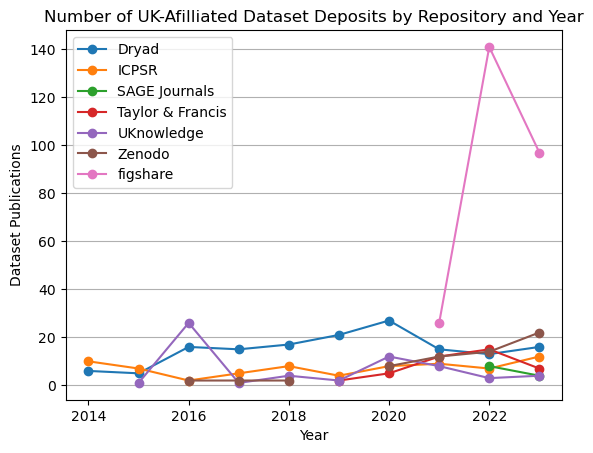

In [9]:
#plt.figure(figsize=(40, 12))
repo_count = metadata_df_filtered.groupby(["publicationYear", "repository"]).size().unstack()
repo_count.plot(kind="line", marker="o")
plt.xlabel('Year')
plt.ylabel('Dataset Publications')
plt.grid(axis='y')
plt.title('Number of UK-Afilliated Dataset Deposits by Repository and Year')
plt.legend(loc='best')
plt.show()

What's the deal with the massive Figshare usage?

In [10]:
figshare_data = metadata_df_filtered[metadata_df_filtered["repository"] == "figshare"]
figshare_data["ukResearcher"].value_counts()

Li, Jing                    92
Arnett, Donna K.            44
Zhang, Wen                  31
Wang, Lin                   20
Wise, Kiersten A.           20
Zhang, Xiaofei              14
Zhang, Xu                   12
Luo, Dan                     8
Baskin, Carol C.             5
Cain, Jennifer L.            4
Yang, Ling                   2
Lin, Nan                     2
Liu, Jinpeng                 2
Zheng, Fang                  2
Islam, Md. Shariful          2
Bokros, Norbert              2
Kalbfleisch, Theodore S.     2
Name: ukResearcher, dtype: int64

Figshare has a small number of UK superusers. Consider looking repositories by number of individual users.

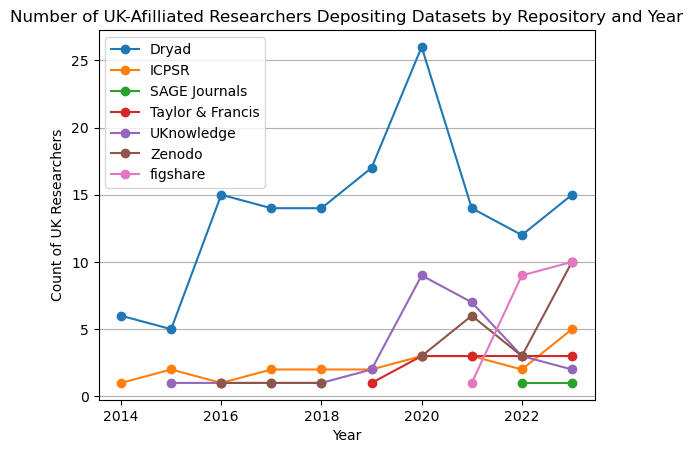

In [11]:
# Group by year and repository, then count the number of unique researchers publishing a dataset in a repository per year
researcher_count = metadata_df_filtered.groupby(["publicationYear", "repository"])['ukResearcher'].nunique().unstack()
researcher_count.plot(kind="line", marker="o")
plt.xlabel('Year')
plt.ylabel('Count of UK Researchers')
plt.grid(axis='y')
plt.title('Number of UK-Afilliated Researchers Depositing Datasets by Repository and Year')
plt.legend(loc='best')
plt.show()

In [12]:
researcher_count

repository,Dryad,ICPSR,SAGE Journals,Taylor & Francis,UKnowledge,Zenodo,figshare
publicationYear,,,,,,,
2014,6.0,1.0,NaN,NaN,NaN,NaN,NaN
2015,5.0,2.0,NaN,NaN,1.0,NaN,NaN
2016,15.0,1.0,NaN,NaN,1.0,1.0,NaN
2017,14.0,2.0,NaN,NaN,1.0,1.0,NaN
2018,14.0,2.0,NaN,NaN,1.0,1.0,NaN
2019,17.0,2.0,NaN,1.0,2.0,NaN,NaN
2020,26.0,3.0,NaN,3.0,9.0,3.0,NaN
2021,14.0,3.0,NaN,3.0,7.0,6.0,1.0
2022,12.0,2.0,1.0,3.0,3.0,3.0,9.0


## Metadata Completeness

Group datasets by repository:

In [13]:
repos = metadata_df_filtered["repository"].unique()
repo_completeness = {"repository": [], "Creator": [], "Affiliation": [], "Funder": []}
for repo in repos:
    repo_completeness["repository"].append(repo)
    repo_slice = metadata_df_filtered[metadata_df_filtered["repository"] == repo]
    
    creator_proportion = repo_slice[repo_slice["completeCreator"] == True].shape[0] / repo_slice.shape[0]
    repo_completeness["Creator"].append(creator_proportion)
    
    affiliation_proportion = repo_slice[repo_slice["completeAffiliation"] == True].shape[0] / repo_slice.shape[0]
    repo_completeness["Affiliation"].append(affiliation_proportion)
    
    funder_proportion = repo_slice[repo_slice["completeFunder"] == True].shape[0] / repo_slice.shape[0]
    repo_completeness["Funder"].append(funder_proportion)
    
repo_completeness_df = pd.DataFrame(repo_completeness)
repo_completeness_df.set_index('repository', inplace=True)

In [14]:
repo_completeness_df

,Creator,Affiliation,Funder
repository,,,
Zenodo,0.838710,0.064516,0.032258
Dryad,0.496689,1.000000,0.390728
ICPSR,0.000000,0.000000,0.000000
UKnowledge,0.918033,0.475410,0.278689
figshare,0.306818,1.000000,0.000000
Taylor & Francis,0.000000,1.000000,0.000000
SAGE Journals,0.000000,1.000000,0.000000


In [15]:
repo_completeness_df = repo_completeness_df.sort_values(by="Creator", ascending=False)

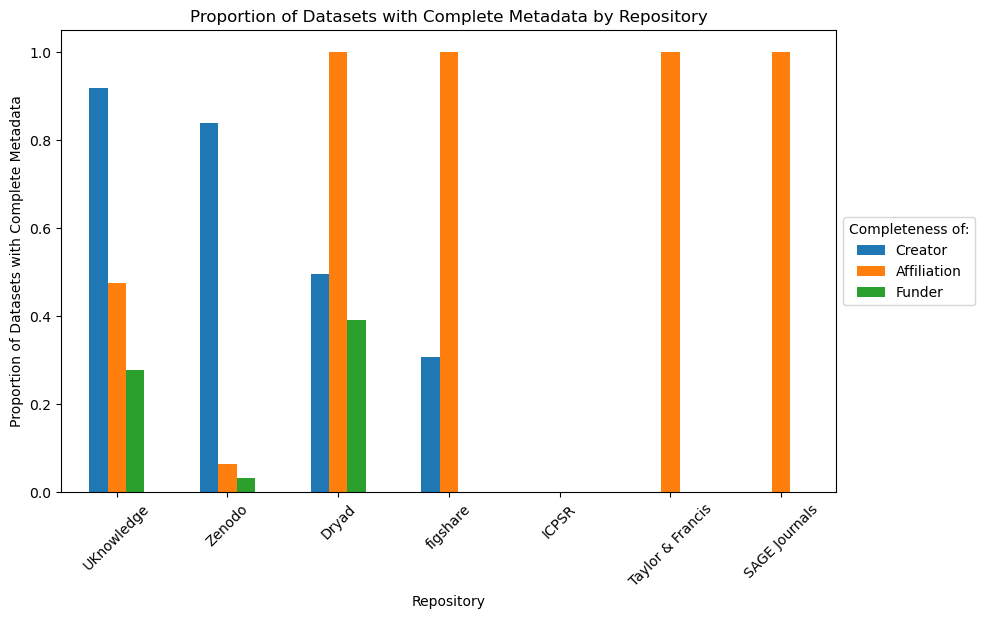

In [16]:
ax = repo_completeness_df.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Repository")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.ylabel("Proportion of Datasets with Complete Metadata")
plt.title("Proportion of Datasets with Complete Metadata by Repository")
#plt.legend(loc='best')
ax.legend(title="Completeness of:", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

## Dryad Usage Stats

Dryad is the only repository that attached usage stats to its DOIs, so how often are they used?

In [42]:
dryad_metrics_df = pd.read_csv("datacite_dois.csv")
dryad_metrics_df = dryad_metrics_df[dryad_metrics_df["repository"] == "Dryad"]

In [69]:
dryad_downloads = dryad_metrics_df["downloadCount"].sort_values(ascending=False)
dryad_views = dryad_metrics_df["viewCount"].sort_values(ascending=False)
dryad_references = dryad_metrics_df["referenceCount"].sort_values(ascending=False)

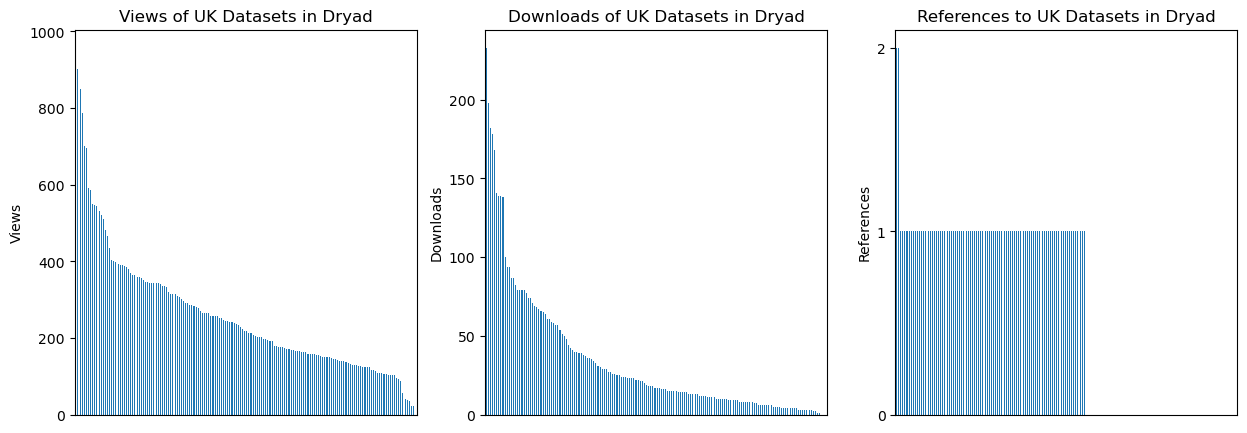

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

dryad_views.plot(kind="bar", ax=ax1)
ax1.set_xticks([])
ax1.set_ylabel("Views")
ax1.set_title("Views of UK Datasets in Dryad")

dryad_downloads.plot(kind="bar", ax=ax2)
ax2.set_xticks([])
ax2.set_ylabel("Downloads")
ax2.set_title("Downloads of UK Datasets in Dryad")

dryad_references.plot(kind="bar", ax=ax3)
ax3.set_xticks([])
ax3.set_ylabel("References")
ax3.set_yticks([0, 1, 2])
ax3.set_title("References to UK Datasets in Dryad")


plt.show()